In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, when
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import Vectors
from pyspark.sql.window import Window

In [20]:
if 'spark' in globals():
    spark.stop()

In [22]:
spark = SparkSession.builder \
    .appName("PulseGuard") \
    .master("local[*]") \
    .config("spark.ui.port", "4040") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .getOrCreate()


In [23]:

import pandas as pd 

df = pd.read_csv(r"E:\CNR_2025\data\raw\PulseDB\PulseDB_Vital\p000001.csv")

# Save as Parquet
df.to_parquet("p000001.parquet", engine="pyarrow")



In [25]:
df = spark.read.csv(r"E:\CNR_2025\data\raw\PulseDB\PulseDB_Vital\p000001.csv", header=True, inferSchema=True)


In [26]:

selected_columns = [
    "PPG_F", "ABP_F", "Age", "Gender", "Height", "Weight", "BMI", "T", "SegSBP", "SegDBP"
]

# Keep only the selected columns in the DataFrame
df = df.select(*selected_columns)

In [27]:
df = df.withColumn(
    "Label",
    when((col("SegSBP") < 120) & (col("SegDBP") < 80), "Normal BP")
    .when((col("SegSBP") >= 120) & (col("SegSBP") < 130) & (col("SegDBP") < 80), "Elevated BP")
    .when((col("SegSBP") >= 130) & (col("SegSBP") < 140) & (col("SegDBP") >= 80) & (col("SegDBP") < 90), "Hypertension Stage 1")
    .when((col("SegSBP") >= 140) & (col("SegDBP") >= 90), "Hypertension Stage 2")
    .when((col("SegSBP") > 180) | (col("SegDBP") > 120), "Hypertensive Crisis")
    .otherwise("Normal BP")
)

In [28]:
# Group by the 'Label' column and count the occurrences
label_counts = df.groupBy("Label").count()

# Show the result
label_counts.show()

+--------------------+-------+
|               Label|  count|
+--------------------+-------+
|Hypertension Stage 1|    104|
|           Normal BP|1144707|
|Hypertension Stage 2|    101|
|         Elevated BP|     88|
+--------------------+-------+



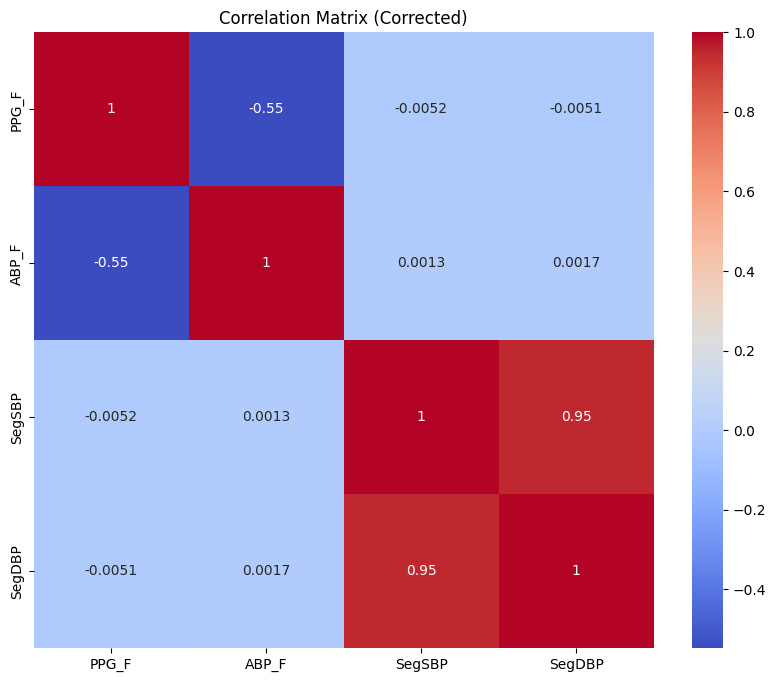

In [29]:

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



# Select the columns that you want to analyze (modify this to suit your dataset)
selected_cols = ["PPG_F", "ABP_F", "SegSBP", "SegDBP"]

# Assemble features into one vector column
assembler = VectorAssembler(inputCols=selected_cols, outputCol="features")
df_vector = assembler.transform(df).select("features")

# Compute correlation matrix
correlation_matrix = Correlation.corr(df_vector, "features").head()[0].toArray()

# Plot using matplotlib & seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", xticklabels=selected_cols, yticklabels=selected_cols)
plt.title("Correlation Matrix (Corrected)")
plt.show()


In [30]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, when, count
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType


# 2. Index label
indexer = StringIndexer(inputCol="Label", outputCol="label_index")
df = indexer.fit(df).transform(df)

# 3. Handle class imbalance (get label weights)
label_dist = df.groupBy("label_index").agg(count("*").alias("count")).toPandas()
total = label_dist["count"].sum()
label_weights = {row["label_index"]: total / row["count"] for _, row in label_dist.iterrows()}



get_weight = udf(lambda label: float(label_weights.get(label, 1.0)), DoubleType())
df = df.withColumn("class_weight", get_weight(col("label_index")))

# 5. Assemble features
assembler = VectorAssembler(
    inputCols=["PPG_F", "ABP_F", "Age", "Gender", "Height", "Weight", "BMI", "T"],
    outputCol="features"
)
df = assembler.transform(df)


In [18]:
df.select("features").printSchema()


root
 |-- features: vector (nullable = true)



In [32]:
# 6. Train-test split
train, test = df.randomSplit([0.8, 0.2], seed=42)

# 7. Train Random Forest with weights
rf = RandomForestClassifier(featuresCol="features", labelCol="label_index", weightCol="class_weight", numTrees=100)
small_train = train.limit(100)
model = rf.fit(small_train)


Py4JJavaError: An error occurred while calling o743.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 4 in stage 18.0 failed 1 times, most recent failure: Lost task 4.0 in stage 18.0 (TID 70) (DESKTOP-JB52V93 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:54)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:551)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:519)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 29 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:54)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:551)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:519)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 29 more


In [ ]:
# 8. Evaluate
predictions = model.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(predictions)

print("F1-score:", f1_score)

In [ ]:
    dataset_url = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/t93xcwm75r-11.zip"